# Progettino AQM

# Alla ricerca dell'autovalore dello stato fondamentale dell'hamiltoniana

#### Autori:
Dott. Michele Grossi<br>
Francesco De Luca<br>
Ian Gremese<br>
Carlo Zollo

##### Cose che sarebbe interessante integrare prima della fine
Guardare oltre che le energie anche la forma dei singoli gs <br>
Trovare un modo per misurare le prestazioni <br>
Hardware reale è tanta sbatta <br>
Trovare simmetrie nell'hamiltoniana per ottimizzare ansatz<br>
Riuscire a scrivere circuito associato all'hamiltoniana(come? per quanti gates)?<br>

### Armamentario generale, da caricare prima delle diverse operazioni

#### Diagonalizzazione computazionale "classica"

Codice funzionale alla compilazione delle hamiltoniane da diagonalizzare.

Importiamo operatori e matrici di Pauli

In [1]:
from qiskit.quantum_info.operators import Operator, Pauli

Funzione per la diagonalizzazione classica di una lista di lunghezza variabile di operatori $\hat H$, che ha la forma `([H0, H1, H2, ...], )`.

In [2]:
import numpy as np
from numpy import linalg

def class_par_H_diagonalizer(*H):
    E_l = []
    P_l = []
    Eivals = []
    GSvals = []
    num_qubits = 2

    for k in H[0]: #H is ([H0, H1, ...],), so Hj can be selected as H[0][j]
        E_l, P_l = linalg.eig(k.data)
        E_l = np.real(E_l)
        Eivals.append(np.sort(E_l))
        GSvals.append(np.min(E_l))
        
    return GSvals, Eivals

Funzione per il grafico dei soli valori della diagonalizzazione classica.

In [3]:
import matplotlib.pyplot as plt

def plot_class(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)#, fontsize=8)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

#### Diagonalizzazione quantistica con il VQE

Codice per la scrittura delle hamiltoniane da diagonalizzare:

In [4]:
import numpy as np
from numpy import linalg
from qiskit.opflow import X, Y, Z, I, primitive_ops

Funzione che cerca il minimo autovalore dell'hamiltoniana:

In [5]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
from qiskit.algorithms import VQE

def VQE_par_H_diagonalizer(local_vqe,*H):
    
    #Ci riferiamo alla variabile globale
    #perché cambia il modo in cui la "passa".
    #Se non facciamo così dopo non riesce a modificarla
    global intermediate_info
    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    
    GSvals = []
    meanerr = []
    
    for i in range(len(H[0])):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H[0])))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
        GSvals.append(np.real(local_result.eigenvalue))
        
        meanerr.append(intermediate_info['stddev'][-1])
    
    ipd_clear(wait=True)
    ipd_display("Finito.")
    
    return GSvals, meanerr

Funzione per la raccolta di dati relativi all'ottimizzazione del VQE:

In [6]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    global intermediate_info
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [7]:
#import matplotlib as mpl
#mpl.rcParams.update({'font.family': 'Linux Libertine', 'text.latex.preamble': r'\usepackage{lmr}',})

Funzione per il grafico dei valori della diagonalizzazione classica e quantistica:

In [8]:
import matplotlib.pyplot as plt

def plot_tot(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(9,6), dpi=100)

    plt.xticks(B)

    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)
    
    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.scatter(B, lists[i], marker='x')

    ax.set(xlabel='B field', ylabel='Energy', title='')

    ax.grid()
    plt.show()

## Hamiltoniana n. 2: Interazioni anisotrope fra spin in campo magnetico $B$

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat X^{(i)}\hat X^{(j)} + g_y\hat Y^{(i)}\hat Y^{(j)} + g_z\hat Z^{(i)}\hat Z^{(j)} \right) - B \sum_{i=1}^n Z^{(i)}$$

### Valori dei parametri
Definiamo i valori dei parametri presenti nell'espressione dell'hamiltoniana:

I valori dei parametri dovrebbe passare da un rapporto $B/J$ grande tra termine di campo e spin (circa 4) ad un rapporto piccolo (circa 0.1). Circa citando il paper di grossi, quando il termine di campo è più forte dovremmo tendere ad effetto Zeeman, il GS tende allo stato con tutti gli spin allineati verso il basso. Quando il termine di spin domina invece ci aspettiamo che il GS sia entanglement di stati con spin su e giù.

In [9]:
Natoms = 2  ##Il numero di atomi cambierà poi
J = -5.
gy = 0.5
gz = 0
B = np.linspace(-10,3,8).tolist()

### Diagonalizzazione computazionale "classica"

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$:

In [10]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

##La versione "classica" di questa funzione utilizza Operatori del tipo Operators, che un eigensolver classico può utilizzare


def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction

    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field=(field^I)+(B*((I^i)^Z))
        spin=spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin += ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin += (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            spin += (J*gz*((I^j)^Z^(I^(i-j-1))^Z))
            
    return(spin+field)

In [11]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

#### Algoritmo per risoluzione classica

Invochiamo la funzione per la diagonalizzazione classica computazionale:

In [12]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

Visualizziamo il grafico degli autovalori determinati classicamente:

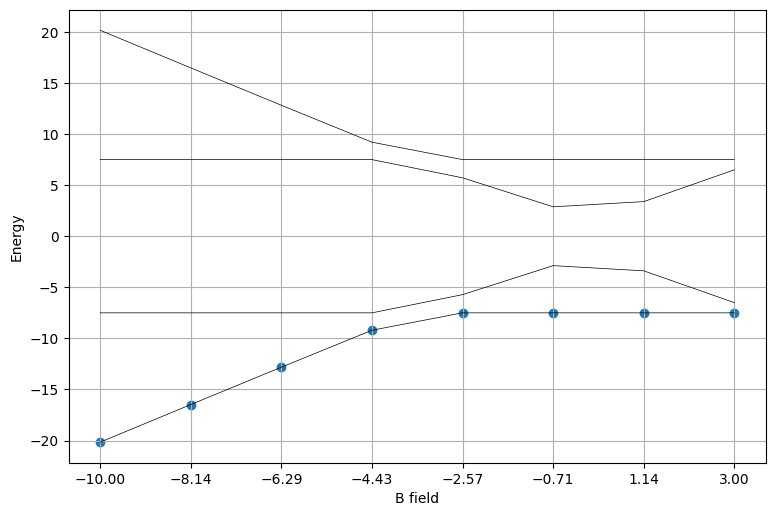

In [13]:
plot_class([cGSEigE, EigE])

Nota: ci interesserebbe anche trovare gli autovettori per avere qualche insight in più su come si potrebbe ottimizzare l'ansatz.

### Diagonalizzazione quantistica con il VQE - Locale

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$:

In [14]:
##La versione quantistica utilizza operatori del tipo PauliOp che è l'unico tipo che l'algoritmo VQE accetta

def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field += primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins += primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)
            spins += primitive_ops.PauliOp(Pauli('I'*j+'Z'+'I'*(i-j-1)+'Z'+'I'*(Natoms-i-1)),J*gz)

    return (field+spins),Operator((field+spins).to_matrix())

In [15]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) #dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

#### Algoritmo

Facciamo una scelta dell'ansatz, fra `EfficientSU2` ecc., impostandone i parametri secondo la definizione che abbiamo dato al nostro problema.

### Importante
La scelta di un buon circuito di ansatz è cruciale per rendere l'algoritmo efficiente. Restringere lo spazio di hilbert ad una dimensione più piccola possibile è molto molto importante. EfficientSU2 è un approccio euristico alla faccenda. Forse leggendo l'articolo di Grossi si capirà qualcosa di più. Finora è chiaro che: <br>
-Hamiltoniana commuta con la coniugazione complessa-> Autostati (e quindi GS) sono reali <br>
-Hamiltoniana commuta con (Spin Totale)(x + y +z)^2? <br>
-Hamiltoniana commuta con Spinz?

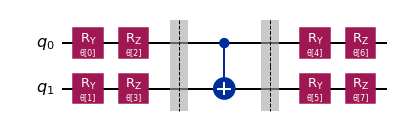

In [16]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

Scegliamo l'ottimizzatore per il VQE fra `SPSA`, `COBYLA` ecc.: 

In [17]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

Costruiamo la funzione per il VQE con ansatz, ottimizzatore, stato iniziale, "quantum instance" e funzione di callback scelti e facciamo eseguire il VQE con i parametri scelti:

In [18]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator

import time

start_time = time.time()


local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

print(time.time()-start_time)

'Finito.'

17.99174690246582


Aggiunto una funzione di time alla VQE per verificare che succede con Ottimizzatori diversi. Non è un indicatore troppo veritiero ma ci da un'idea

#### Risultati

Visualizzo stime delle energie dei GS e stime degli errori:

In [19]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-20.029296875 0.17995307825711754
-16.199916294642858 0.18164818072891165
-12.865652901785715 0.18583488417032507
-8.606026785714286 0.19053916119984168
-7.087751116071429 0.10026201498941656
-6.918247767857142 0.06401939282795667
-7.419921875 0.03163163429098097
-6.366210937499999 0.18458629468315854


Visualizzo il grafico con i risultati classici e della VQE:

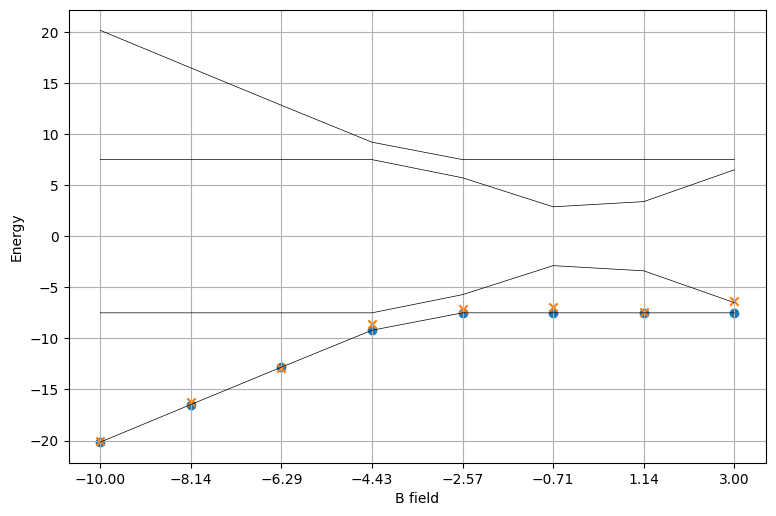

In [20]:
plot_tot([cGSEigE, EigE, qGSEigE])

### Caso con N atomi

Riproviamo come prima con più atomi

In [21]:
cH = []
Natoms=6 #Cambiamo numero atomi
J = -5.
gy = 0.5
gz = 0
B = np.linspace(-10,3,8).tolist()

#### Diagonalizzazione computazionale "classica"

In [22]:
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

Sembra che in class_par_H_diagonalizer k.data estragga la matrice sia che sia fatta con opflow sia che sia fatta con la libreria Pauli_operators e quindi funziona comunque

In [23]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

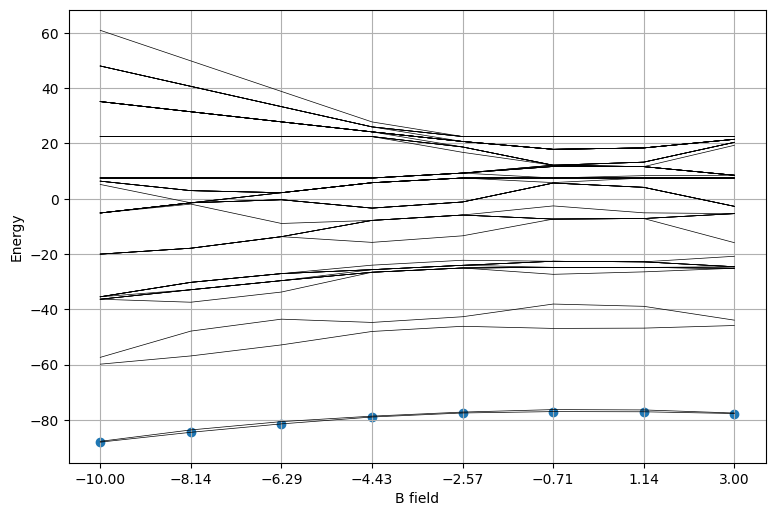

In [24]:
plot_class([cGSEigE, EigE])

#### Diagonalizzazione quantistica con il VQE

In [25]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

Ora proviamo a vedere se riusciamo a fare vqe. Prima in locale poi con il runtime (Sui simulatori/Hardware vero dell'IBM)

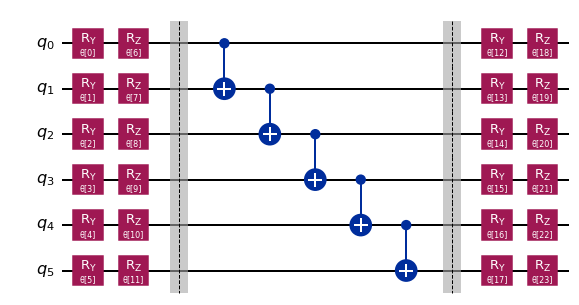

In [26]:
from qiskit.circuit.library import EfficientSU2

num_qubits = Natoms
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

##### Scelta di ottimizzatore vqe

Scegliamo l'ottimizzatore per il VQE fra `SPSA`, `COBYLA` ecc.: 

In [27]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

maxiter=400 #Numero di iterazioni massime (con 50 nel range tra simmetrico 1.8 converge molto molto poco)

optimizer = SPSA(maxiter=maxiter)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Local VQE

Inizializziamo con QasmSimulatorPy, il simulatore locale della vqe. 

In [28]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [29]:
qGSEigE, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

In [30]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-65.95703125 1.0892446573580385
-82.80719866071428 0.8616225511156483
-78.5712890625 0.7447565179457274
-76.34793526785714 0.6021863331849135
-76.32645089285714 0.39489174608184613
-75.02232142857144 0.3785149736865399
-75.38141741071428 0.3452875736653326
-74.26171875000001 0.39218903233506147


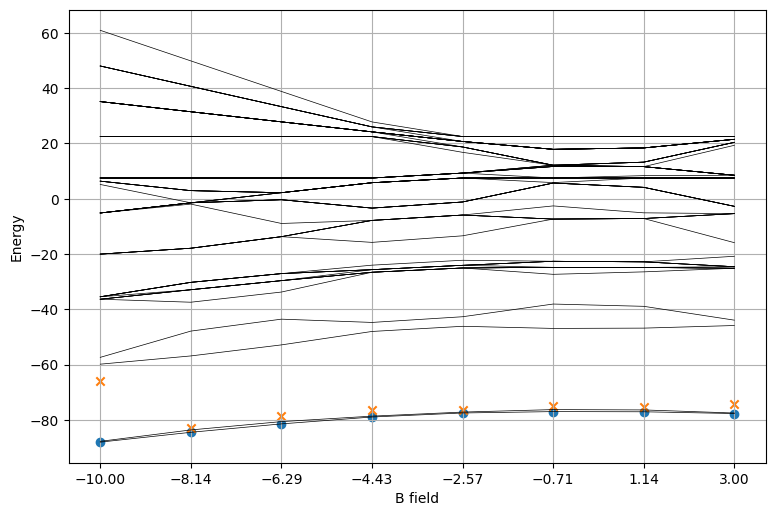

In [31]:
plot_tot([cGSEigE, EigE, qGSEigE])

##### Problema risolto, era l'hamiltoniana sbagliata
Visualizzo il grafico con i risultati classici e della VQE: Strano, tutte le energie di vqe sono abbastanza sicure di essere sotto il gs. Proviamo a controllare che le hamiltoniane siano uguali:

In [32]:
for k in range(len(B)):
    print(np.nonzero((Operator(qH[k])-cH[k])))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


#### Hardware/Simulator VQE

Proviamo con Hardware reale

In [33]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise
from qiskit_nature.runtime import VQEProgram, VQEClient
from qiskit.test.mock import FakeVigo

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy #si può cercare l'equivalente Aer
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

##### Accesso a IBM Quantum

In [34]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

##### Assegnazione dell'hardware e configurazione dell'esecuzione

Funzione che costruisce prima la quantum instance, poi l'istanza della VQE a partire dai parametri immessi dall'utente relativamente a:
- strumentazione: hardware, simulatore con/senza rumore;
- numero di <i>shots</i>;
- ottimizzatore: SPSA, COBYLA ecc.:

In [35]:
def Custom_VQE_diag(BK,shots,optimizer):
    
    #Parte 1: definisco la quantum_instance
    
    #HW = 'ibmq_belem'
    BK = "noiseless" # "IBMnoisy", "Aernoisy", "noiseless", "hardware"

    if BK == "noiseless":

        backend = Aer.get_backend("aer_simulator")
        quantum_instance = QuantumInstance(backend,
                                           shots=shots)

        print(quantum_instance)

    if BK == "IBMnoisy":

        #device = IBMQ.get_provider().get_backend(HW)
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and x.configuration().simulator))
        prop = backend.properties()
        #print(dir(backend.configuration()))
        #print(dir(backend.options))

        coupling_map = backend.configuration().coupling_map
        noise_model = backend.options.noise_model
        basis_gates = backend.configuration().basis_gates

        #backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend,
                                           shots=shots,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "Aernoisy":

        #Aer.backends()
        backend = Aer.get_backend('aer_simulator')
        #prop = backend.properties()
        #print(dir(backend))

        #Prendo i modelli per la simulazione con rumore da FakeVigo
        device = QasmSimulator.from_backend(FakeVigo())
        
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates

        #seed = 170
        #iterations = 125
        #algorithm_globals.random_seed = seed

        quantum_instance = QuantumInstance(backend,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           seed_simulator=seed,
                                           seed_transpiler=seed,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "hardware":

        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and not x.configuration().simulator))
        print(backend)
        
    #Parte 2: definisco l'istanza della VQE
        
    if BK in ("IBMnoisy"):
        
        #VQEProgram invece di VQE(usata in sim locale)
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 quantum_instance=quantum_instance, ####
                 callback=callback)

    if BK in ("hardware"):
        
        #VQEProgram o VQEClient?
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 callback=callback)

    if BK in ("Aernoisy","noiseless"):
        
        vqe = VQE(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 quantum_instance=quantum_instance,
                 callback=callback)    
        
    qGSEigE, meanerr = VQE_par_H_diagonalizer(vqe,qH)
    
    return qGSEigE, meanerr

Impostazione dei parametri di strumentazione, <i>shots</i>, ottimizzatore e chiamata della funzione che esegue la VQE:

In [36]:
shots = 1024

# in this first release, the optimizer must be specified as dictionary
#optimizer = {'name': 'SPSA', 'maxiter': 50}
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("IBMnoisy",shots,optimizer)

'Finito.'

##### Risultati

In [37]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-65.791015625 1.2529781745454396
-66.822265625 1.1480513987095895
-57.110909598214306 1.236337858054086
-51.395089285714285 1.1239791226449807
-63.14732142857144 0.9521813275272374
-49.31780133928573 1.0576309086974176
-34.82310267857142 1.0608661669336494
-59.24902343749999 1.0626867437867302


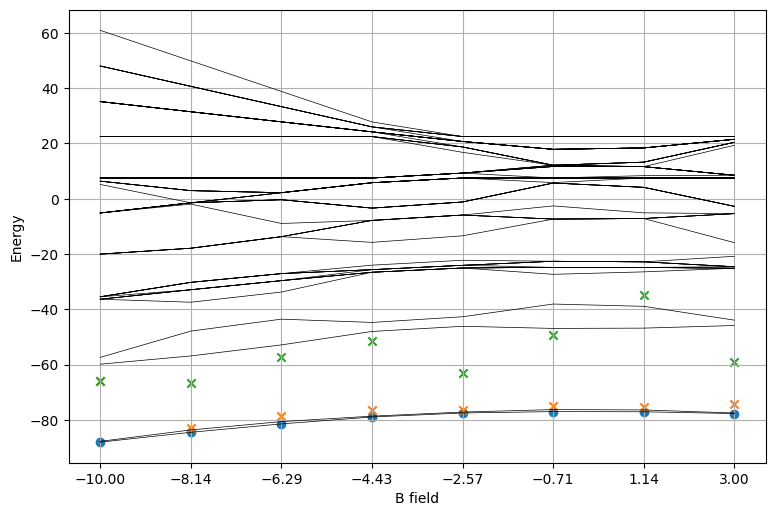

In [38]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1])

## Confronto tra ottimizzatori

A seconda del tipo di ottimizzatore ci aspettiamo performance diverse: Utilizzia gli ottimizzatori COBYLA, L_BFGS, SLSQP, SPSA. Hanno tutti caratteristiche diverse.

###### Questa parte di codice è importata dal main-checkpoint di Carlo, ho provato a integrare al meglio le funzioni definite prima ma potrebbero esserci ripetizioni

In [39]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
import numpy as np
import pylab


#from qiskit.providers.basicaer import QasmSimulatorPy                       # local simulator
from qiskit import Aer                                               #Uso statevector perché più veloce, però non ha errori, altrimenti usa qasm_simulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA      #Importo gli ottimizzatori


np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

# Lista degli ottimizzatori utilizzati
optimizers = [COBYLA(maxiter=30), L_BFGS_B(maxiter=30), SLSQP(maxiter=30), SPSA(maxiter=30)]    #Scegliamo gli ottimizzatori


#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
    
qGSEigE = []    #Valori da mandare nella funzione per i grafici al variare di B
meanerr = []    

for j in range(len(qH)):
    
    for i, optimizer in enumerate(optimizers):
        
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(j+1,len(qH)))
        ipd_display('Optimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')
        #print('\rOptimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')

        #Reset dei valori di callback
        
        global intermediate_info
        intermediate_info = {
            'nfev': [],
            'parameters': [],
            'energy': [],
            'stddev': []
        }
        
        #nfev = []
        #par = []
        #energy = []
        #std = []
    #
        #def callback(eval_count, parameters, mean, stddev):
        #    nfev.append(eval_count)
        #    par.append(parameters)
        #    energy.append(mean)
        #    std.append(stddev)
        
        ##Qui non è molto comodo usare la funzione VQE custom dialog, lasciamo l'implementazione base
        local_vqe = VQE(ansatz=ansatz,
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')),
                    callback=callback)

        result = local_vqe.compute_minimum_eigenvalue(operator=qH[j])
        converge_nfev_qH[j][i] = intermediate_info['nfev']
        converge_parameters_qH[j][i] = intermediate_info['parameters']
        converge_energy_qH[j][i] = intermediate_info['energy']
        converge_stddev_qH[j][i] = intermediate_info['stddev']
        
    qGSEigE.append(converge_energy_qH[j][3][-1])                           #Scegliamo di quale ottimizzatore mostrare i
    meanerr.append(converge_stddev_qH[j][3][-1])                           #risultati(0 sta per COBYLA) 
    
ipd_clear(wait=True)
ipd_display("Completato.")

'Completato.'

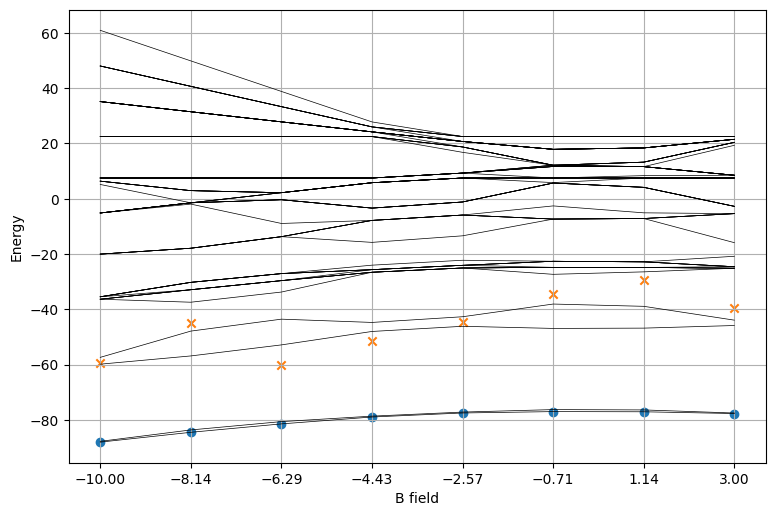

In [40]:
plot_tot([cGSEigE, EigE, qGSEigE])

Visualizziamo le convergenze degli ottimizzatori, a B fissato.

Fissiamo B=0, caso in cui ci aspettiamo massimo entanglement

In [41]:
B_fiss = 0      #Scegli quale passo di B fissare

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

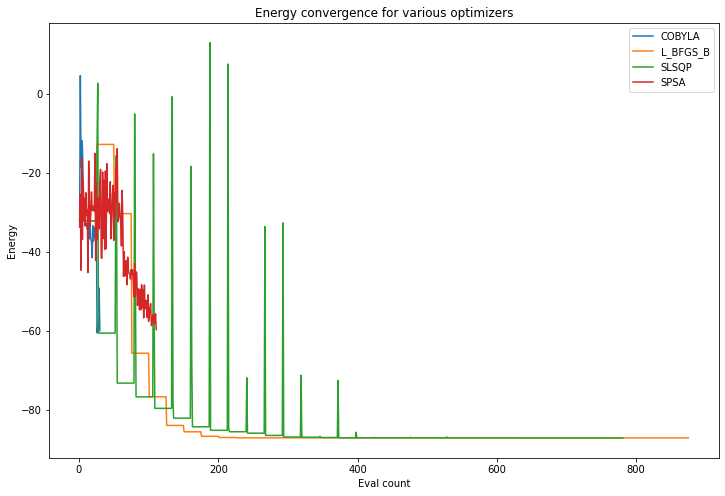

In [42]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], converge_energy_qH[B_fiss][i], label=type(optimizer).__name__)
#print(converge_energy_qH[B_fiss][-1])
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Commenti: perchè L_BFGS_B ha quel picco tra 0 e 50 valutazioni?

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

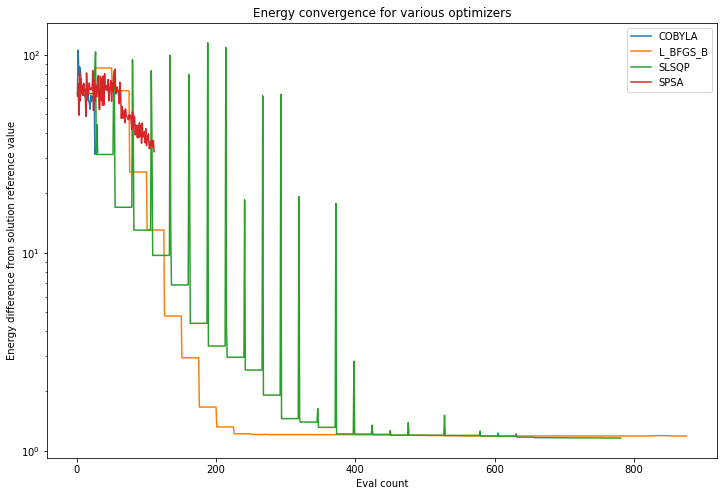

In [43]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], abs(100*(cGSEigE[B_fiss] - converge_energy_qH[B_fiss][i])/cGSEigE[B_fiss]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

Commenti: Nice